In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


Wczytanie i wstępna analiza danych

In [42]:
df = pd.read_csv("jakos_wody.csv")
print(df.head(10))

          ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0        NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1   3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2   8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   
8        NaN  118.988579  14285.583854     7.804174  268.646941    389.375566   
9  11.180284  227.231469  25484.508491     9.077200  404.041635    563.885481   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135   

In [43]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None


In [44]:
print(df.describe())

                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  


Wizualizacja rozkładu zmiennej docelowej (Potability) i sprawdzenie braku danych 

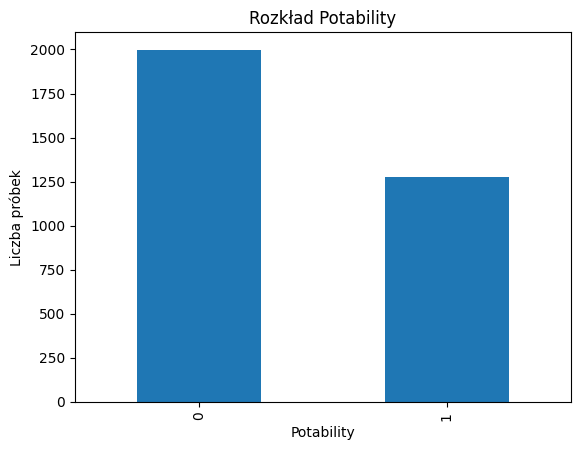

Braki danych:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


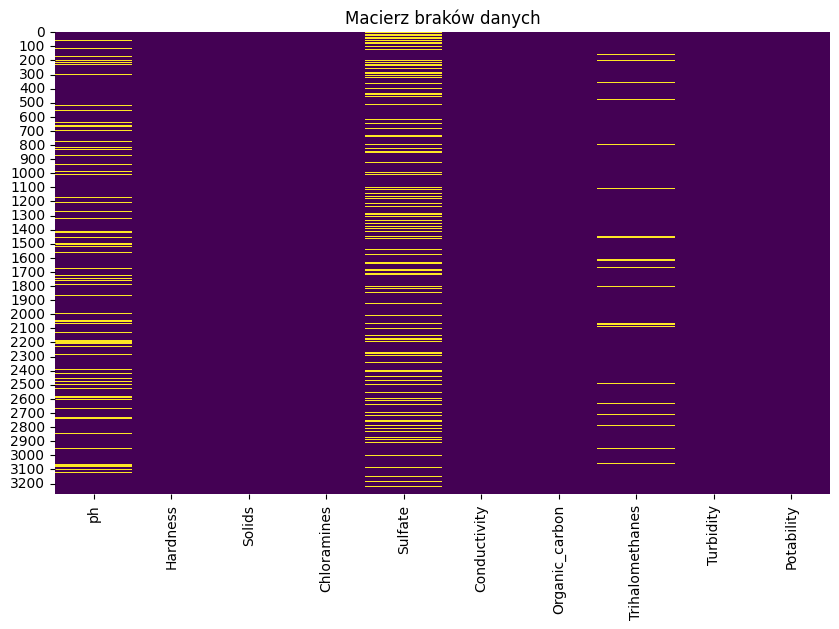

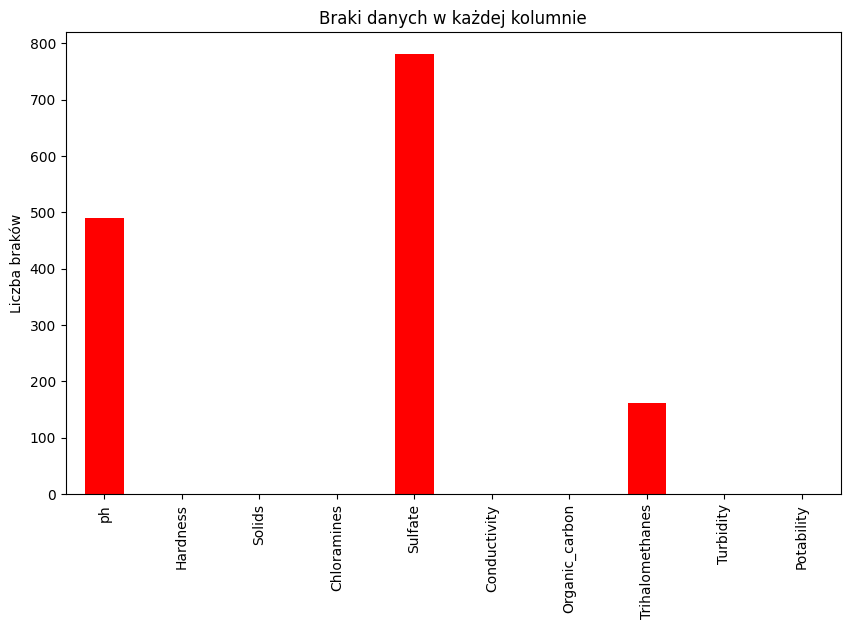

In [45]:
df['Potability'].value_counts().plot(kind='bar')
plt.title('Rozkład Potability')
plt.xlabel('Potability')
plt.ylabel('Liczba próbek')
plt.show()

missing_values = df.isnull().sum()
print("Braki danych:\n", missing_values)

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Macierz braków danych')
plt.show()

missing_values.plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Braki danych w każdej kolumnie')
plt.ylabel('Liczba braków')
plt.show()

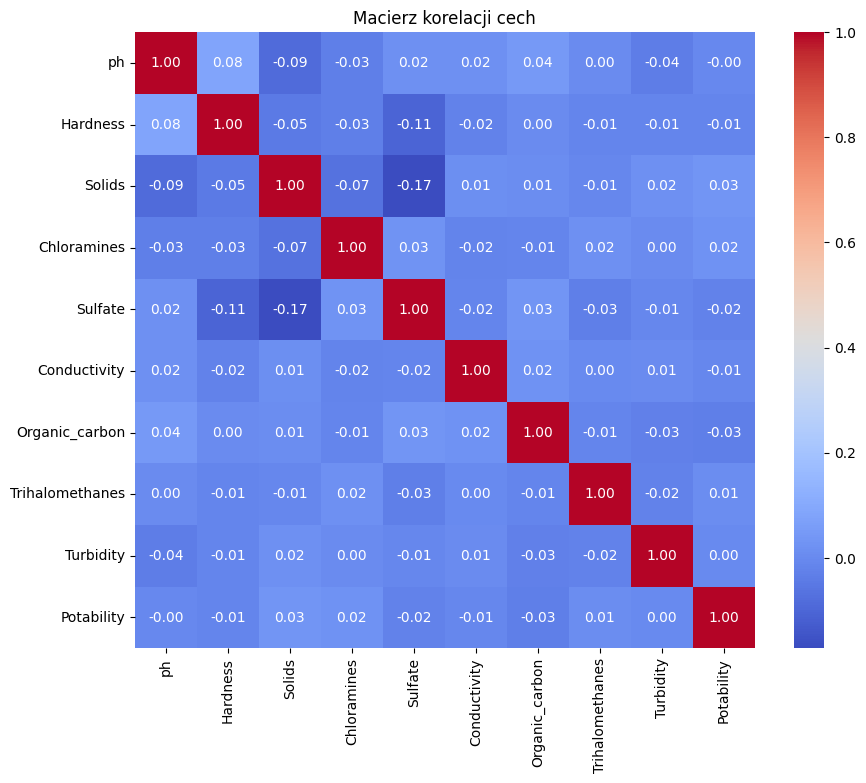

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji cech")
plt.show()

Wizualizacja rozkładów cech dla klas Potability

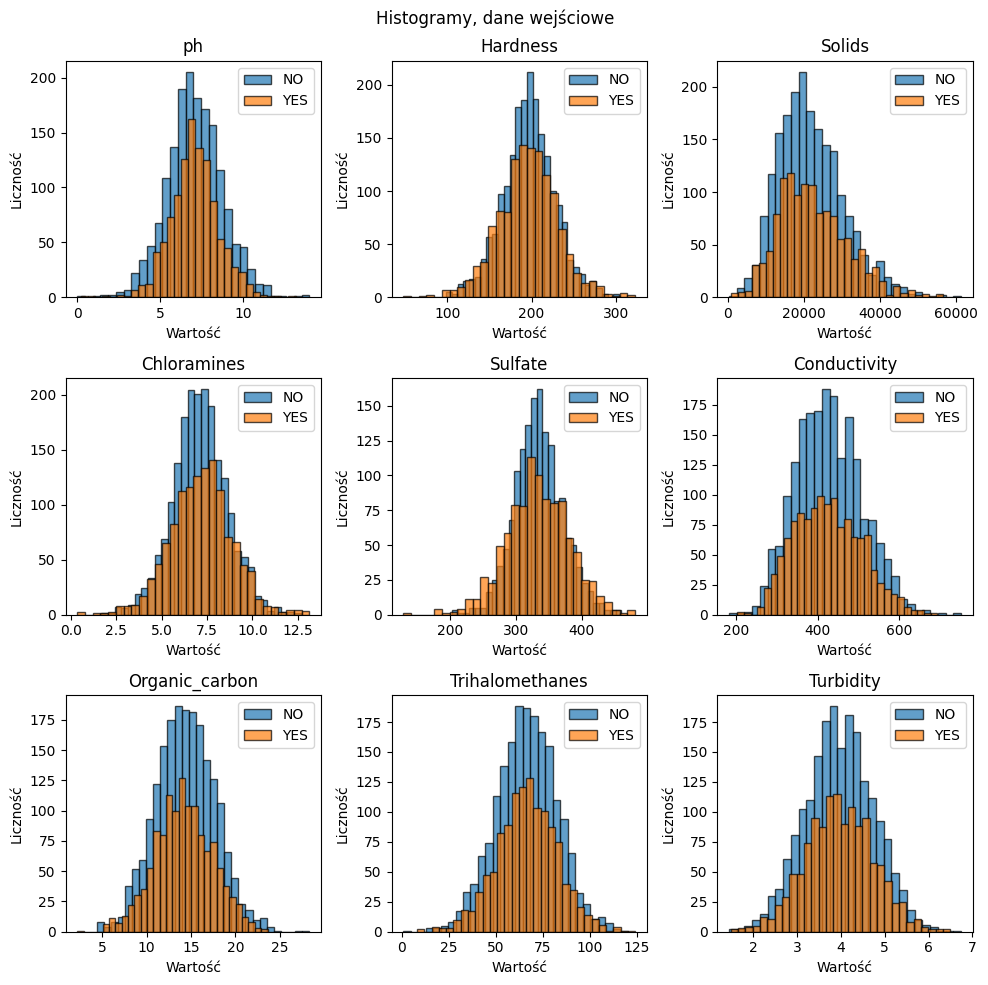

In [47]:

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):  
    ax = axes[i] 
    cl0 = df.loc[df["Potability"] == 0, col]
    cl1 = df.loc[df["Potability"] == 1, col]

    ax.hist(cl0, bins=30, alpha=0.7, label="NO", edgecolor='black')
    ax.hist(cl1, bins=30, alpha=0.7, label="YES", edgecolor='black')

    ax.legend()
    ax.set_title(col)
    ax.set_xlabel("Wartość")
    ax.set_ylabel("Liczność")

plt.suptitle("Histogramy, dane wejściowe")
plt.tight_layout()
plt.show()



Imputacja braków danych i testowanie modeli klasyfikacyjnych


Wyniki dla metody : Drop 
KNN: Accuracy: 0.6572847682119205, Precision: 0.6415094339622641, Recall: 0.2869198312236287, F1-score: 0.3965014577259475
SVM: Accuracy: 0.6986754966887417, Precision: 0.7722772277227723, Recall: 0.3291139240506329, F1-score: 0.46153846153846156
Decision Tree: Accuracy: 0.652317880794702, Precision: 0.6421052631578947, Recall: 0.25738396624472576, F1-score: 0.3674698795180723


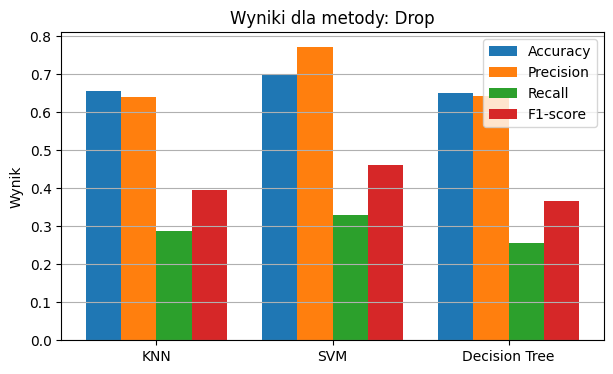


Wyniki dla metody : Mean 
KNN: Accuracy: 0.6439471007121058, Precision: 0.5851851851851851, Recall: 0.21179624664879357, F1-score: 0.3110236220472441
SVM: Accuracy: 0.6754832146490336, Precision: 0.7142857142857143, Recall: 0.24128686327077747, F1-score: 0.36072144288577157
Decision Tree: Accuracy: 0.6408952187182095, Precision: 0.6020408163265306, Recall: 0.1581769436997319, F1-score: 0.2505307855626327


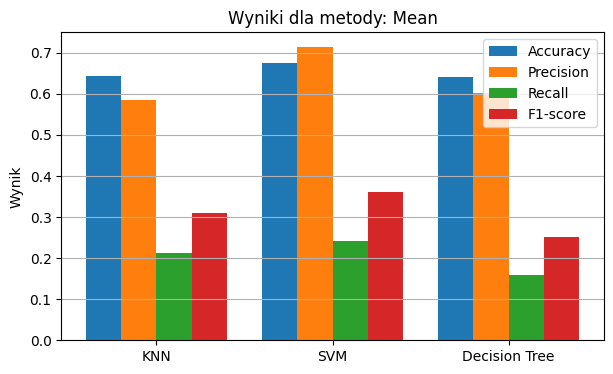


Wyniki dla metody : Median 
KNN: Accuracy: 0.6449643947100712, Precision: 0.5857142857142857, Recall: 0.21983914209115282, F1-score: 0.31968810916179335
SVM: Accuracy: 0.6724313326551373, Precision: 0.7073170731707317, Recall: 0.23324396782841822, F1-score: 0.35080645161290325
Decision Tree: Accuracy: 0.641912512716175, Precision: 0.6082474226804123, Recall: 0.1581769436997319, F1-score: 0.251063829787234


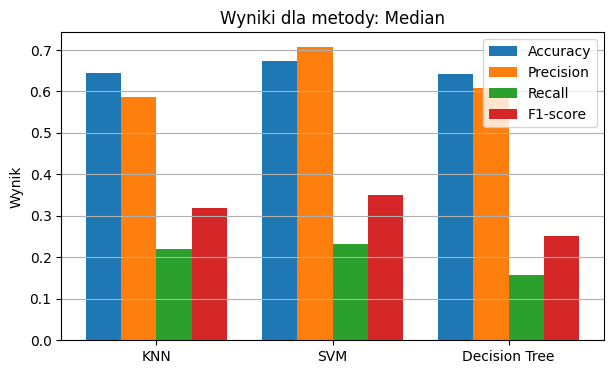


Wyniki dla metody : Mode 
KNN: Accuracy: 0.6459816887080366, Precision: 0.5886524822695035, Recall: 0.2225201072386059, F1-score: 0.3229571984435798
SVM: Accuracy: 0.669379450661241, Precision: 0.7727272727272727, Recall: 0.18230563002680966, F1-score: 0.2950108459869848
Decision Tree: Accuracy: 0.6347914547304171, Precision: 0.54375, Recall: 0.23324396782841822, F1-score: 0.32645403377110693


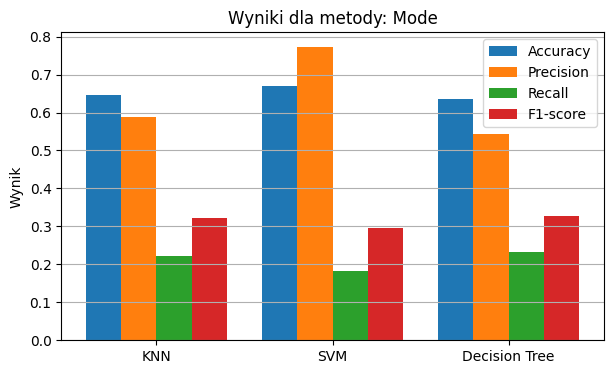


Wyniki dla metody : KNN dla k = 5 
KNN: Accuracy: 0.6368260427263479, Precision: 0.5597014925373134, Recall: 0.20107238605898123, F1-score: 0.2958579881656805
SVM: Accuracy: 0.6724313326551373, Precision: 0.6917293233082706, Recall: 0.24664879356568364, F1-score: 0.36363636363636365
Decision Tree: Accuracy: 0.6520854526958291, Precision: 0.6148148148148148, Recall: 0.2225201072386059, F1-score: 0.32677165354330706


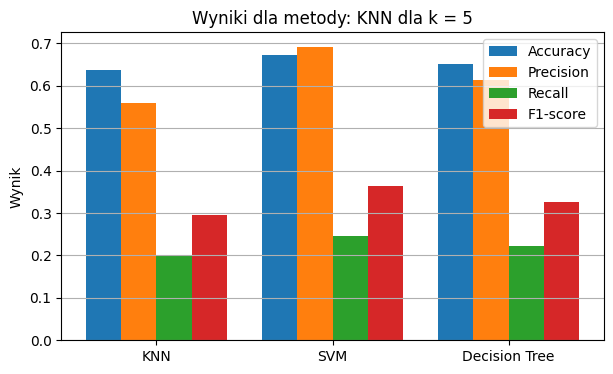


Wyniki dla metody : KNN dla k = 10 
KNN: Accuracy: 0.6429298067141404, Precision: 0.582089552238806, Recall: 0.20911528150134048, F1-score: 0.3076923076923077
SVM: Accuracy: 0.6703967446592065, Precision: 0.6929133858267716, Recall: 0.2359249329758713, F1-score: 0.352
Decision Tree: Accuracy: 0.6358087487283826, Precision: 0.5454545454545454, Recall: 0.24128686327077747, F1-score: 0.3345724907063197


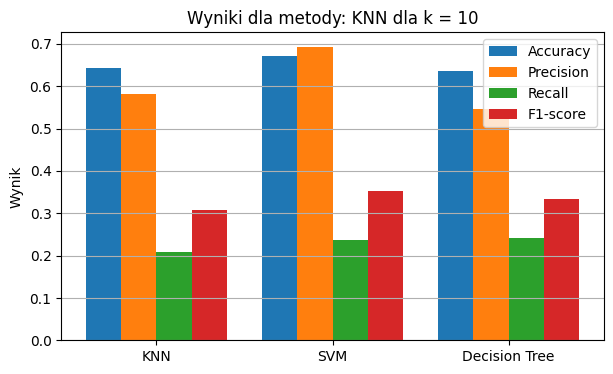


Wyniki dla metody : KNN dla k = 20 
KNN: Accuracy: 0.6408952187182095, Precision: 0.572463768115942, Recall: 0.21179624664879357, F1-score: 0.30919765166340507
SVM: Accuracy: 0.6744659206510681, Precision: 0.7086614173228346, Recall: 0.24128686327077747, F1-score: 0.36
Decision Tree: Accuracy: 0.6429298067141404, Precision: 0.61, Recall: 0.16353887399463807, F1-score: 0.25792811839323465


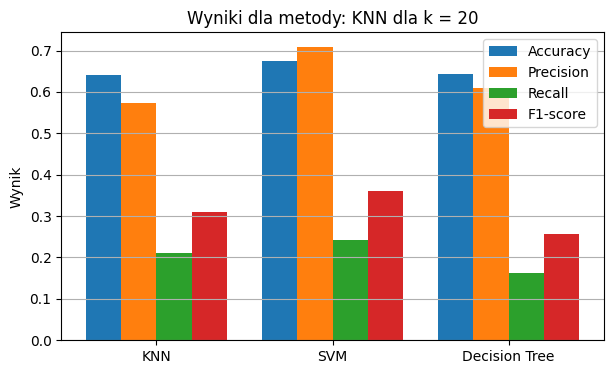


Wyniki dla metody : Iterative (10 iteracji) 
KNN: Accuracy: 0.6368260427263479, Precision: 0.5571428571428572, Recall: 0.20911528150134048, F1-score: 0.30409356725146197
SVM: Accuracy: 0.6724313326551373, Precision: 0.7256637168141593, Recall: 0.21983914209115282, F1-score: 0.3374485596707819
Decision Tree: Accuracy: 0.6398779247202442, Precision: 0.5555555555555556, Recall: 0.2546916890080429, F1-score: 0.3492647058823529


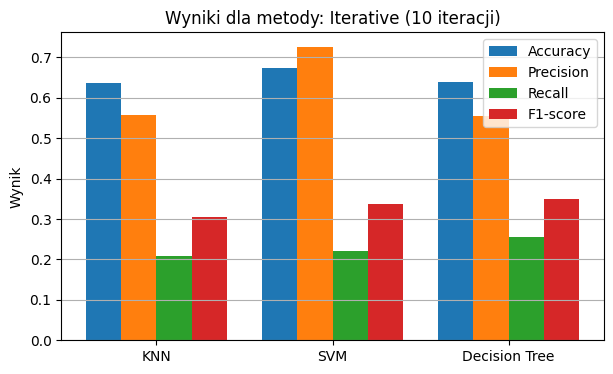


Wyniki dla metody : Iterative (20 iteracji) 
KNN: Accuracy: 0.6368260427263479, Precision: 0.5571428571428572, Recall: 0.20911528150134048, F1-score: 0.30409356725146197
SVM: Accuracy: 0.6724313326551373, Precision: 0.7256637168141593, Recall: 0.21983914209115282, F1-score: 0.3374485596707819
Decision Tree: Accuracy: 0.6388606307222787, Precision: 0.5517241379310345, Recall: 0.257372654155496, F1-score: 0.3510054844606947


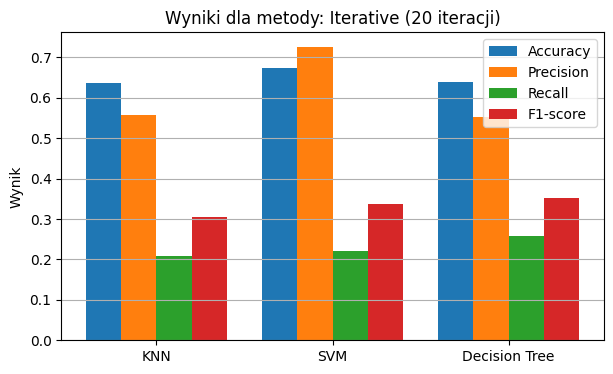


Wyniki dla metody : Iterative (DecisionTree) 
KNN: Accuracy: 0.6408952187182095, Precision: 0.5704225352112676, Recall: 0.21715817694369974, F1-score: 0.3145631067961165
SVM: Accuracy: 0.6775178026449644, Precision: 0.7295081967213115, Recall: 0.2386058981233244, F1-score: 0.3595959595959596
Decision Tree: Accuracy: 0.6561546286876907, Precision: 0.6446280991735537, Recall: 0.20911528150134048, F1-score: 0.3157894736842105


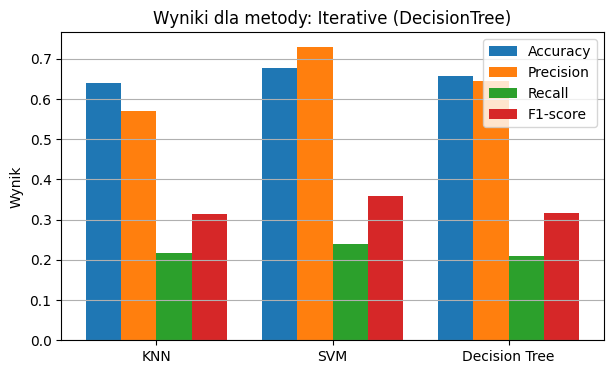

In [48]:
df_drop = df.dropna()
df_mean = df.copy()
df_median = df.copy()
df_mode = df.copy()
df_knn_5 = df.copy()
df_knn_10 = df.copy()
df_knn_20 = df.copy()
df_iter_10 = df.copy()
df_iter_20 = df.copy()
df_iter_dt = df.copy()

imputer_mean = SimpleImputer(strategy="mean")
df_mean.iloc[:, :-1] = imputer_mean.fit_transform(df_mean.iloc[:, :-1])

imputer_median = SimpleImputer(strategy="median")
df_median.iloc[:, :-1] = imputer_median.fit_transform(df_median.iloc[:, :-1])

imputer_mode = SimpleImputer(strategy="most_frequent")
df_mode.iloc[:, :-1] = imputer_mode.fit_transform(df_mode.iloc[:, :-1])

imputer_knn_5 = KNNImputer(n_neighbors=5)
df_knn_5.iloc[:, :-1] = imputer_knn_5.fit_transform(df_knn_5.iloc[:, :-1])

imputer_knn_10 = KNNImputer(n_neighbors=10)
df_knn_10.iloc[:, :-1] = imputer_knn_10.fit_transform(df_knn_10.iloc[:, :-1])

imputer_knn_20 = KNNImputer(n_neighbors=20)
df_knn_20.iloc[:, :-1] = imputer_knn_20.fit_transform(df_knn_20.iloc[:, :-1])

imputer_iter_10 = IterativeImputer(max_iter=10, random_state=42)
df_iter_10.iloc[:, :-1] = imputer_iter_10.fit_transform(df_iter_10.iloc[:, :-1])

imputer_iter_20 = IterativeImputer(max_iter=20, random_state=42)
df_iter_20.iloc[:, :-1] = imputer_iter_20.fit_transform(df_iter_20.iloc[:, :-1])

imputer_iter_dt = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), random_state=42)
df_iter_dt.iloc[:, :-1] = imputer_iter_dt.fit_transform(df_iter_dt.iloc[:, :-1])

scaler = MinMaxScaler()
df_drop.iloc[:, :-1] = scaler.fit_transform(df_drop.iloc[:, :-1])
df_mean.iloc[:, :-1] = scaler.transform(df_mean.iloc[:, :-1])
df_median.iloc[:, :-1] = scaler.transform(df_median.iloc[:, :-1])
df_mode.iloc[:, :-1] = scaler.transform(df_mode.iloc[:, :-1])
df_knn_5.iloc[:, :-1] = scaler.transform(df_knn_5.iloc[:, :-1])
df_knn_10.iloc[:, :-1] = scaler.transform(df_knn_10.iloc[:, :-1])
df_knn_20.iloc[:, :-1] = scaler.transform(df_knn_20.iloc[:, :-1])
df_iter_10.iloc[:, :-1] = scaler.fit_transform(df_iter_10.iloc[:, :-1])
df_iter_20.iloc[:, :-1] = scaler.transform(df_iter_20.iloc[:, :-1])
df_iter_dt.iloc[:, :-1] = scaler.transform(df_iter_dt.iloc[:, :-1])

def split_data(df):
    X = df.iloc[:, :-1].values  
    y = df.iloc[:, -1].values   
    return train_test_split(X, y, test_size=0.3, random_state=0)

X_train_drop, X_test_drop, y_train_drop, y_test_drop = split_data(df_drop)
X_train_mean, X_test_mean, y_train_mean, y_test_mean = split_data(df_mean)
X_train_median, X_test_median, y_train_median, y_test_median = split_data(df_median)
X_train_mode, X_test_mode, y_train_mode, y_test_mode = split_data(df_mode)
X_train_knn_5, X_test_knn_5, y_train_knn_5, y_test_knn_5 = split_data(df_knn_5)
X_train_knn_10, X_test_knn_10, y_train_knn_10, y_test_knn_10 = split_data(df_knn_10)
X_train_knn_20, X_test_knn_20, y_train_knn_20, y_test_knn_20 = split_data(df_knn_20)
X_train_iter_10, X_test_iter_10, y_train_iter_10, y_test_iter_10 = split_data(df_iter_10)
X_train_iter_20, X_test_iter_20, y_train_iter_20, y_test_iter_20 = split_data(df_iter_20)
X_train_iter_dt, X_test_iter_dt, y_train_iter_dt, y_test_iter_dt = split_data(df_iter_dt)

knn = KNeighborsClassifier(n_neighbors=10)
svm = SVC(kernel="rbf")
dt = DecisionTreeClassifier(max_depth=5)

def train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1_metric

for name, X_train, X_test, y_train, y_test in [
    ("Drop", X_train_drop, X_test_drop, y_train_drop, y_test_drop),
    ("Mean", X_train_mean, X_test_mean, y_train_mean, y_test_mean),
    ("Median", X_train_median, X_test_median, y_train_median, y_test_median),
    ("Mode", X_train_mode, X_test_mode, y_train_mode, y_test_mode),
    ("KNN dla k = 5", X_train_knn_5, X_test_knn_5, y_train_knn_5, y_test_knn_5),
    ("KNN dla k = 10", X_train_knn_10, X_test_knn_10, y_train_knn_10, y_test_knn_10),
    ("KNN dla k = 20", X_train_knn_20, X_test_knn_20, y_train_knn_20, y_test_knn_20),
    ("Iterative (10 iteracji)", X_train_iter_10, X_test_iter_10, y_train_iter_10, y_test_iter_10),
    ("Iterative (20 iteracji)", X_train_iter_20, X_test_iter_20, y_train_iter_20, y_test_iter_20),
    ("Iterative (DecisionTree)", X_train_iter_dt, X_test_iter_dt, y_train_iter_dt, y_test_iter_dt)
]:
    print(f"\nWyniki dla metody : {name} ")

    acc_knn, prec_knn, recall_knn, f1_knn = train(knn, X_train, X_test, y_train, y_test)
    print(f"KNN: Accuracy: {acc_knn}, Precision: {prec_knn}, Recall: {recall_knn}, F1-score: {f1_knn}")

    acc_svm, prec_svm, recall_svm, f1_svm = train(svm, X_train, X_test, y_train, y_test)
    print(f"SVM: Accuracy: {acc_svm}, Precision: {prec_svm}, Recall: {recall_svm}, F1-score: {f1_svm}")

    acc_dt, prec_dt, recall_dt, f1_dt = train(dt, X_train, X_test, y_train, y_test)
    print(f"Decision Tree: Accuracy: {acc_dt}, Precision: {prec_dt}, Recall: {recall_dt}, F1-score: {f1_dt}")

    labels = ["KNN", "SVM", "Decision Tree"]
    accuracy = [acc_knn, acc_svm, acc_dt]
    precision = [prec_knn, prec_svm, prec_dt]
    recall = [recall_knn, recall_svm, recall_dt]
    f1_scores = [f1_knn, f1_svm, f1_dt]

    metrics = [accuracy, precision, recall, f1_scores]
    metric_names = ["Accuracy", "Precision", "Recall", "F1-score"]

    plt.figure(figsize=(7, 4))

    for i, metric in enumerate(metrics):
        plt.bar([x + i * 0.2 for x in range(len(labels))], metric, width=0.2, label=metric_names[i])

    plt.xticks([x + 0.3 for x in range(len(labels))], labels)
    plt.ylabel("Wynik")
    plt.title(f"Wyniki dla metody: {name}")
    plt.legend()
    plt.grid(axis="y")
    plt.show()


Porównanie metod imputacji dla wybranych cech

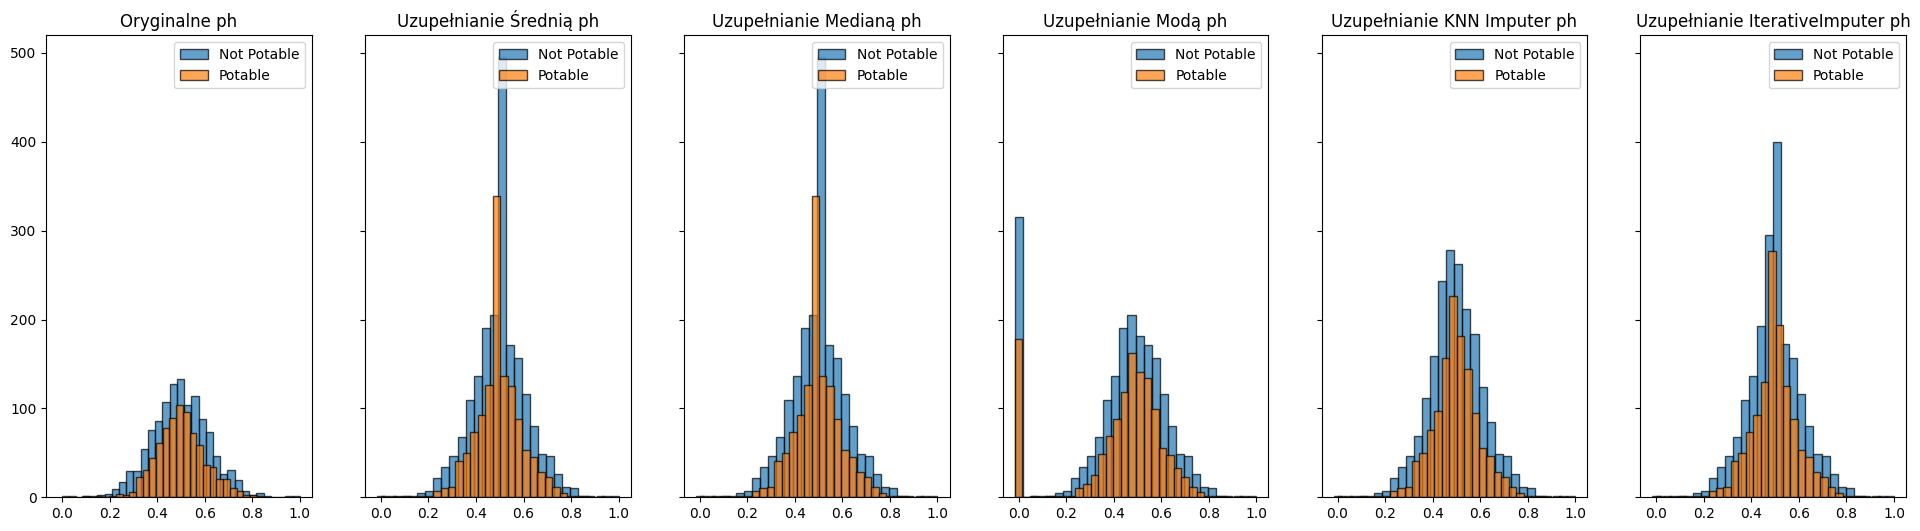

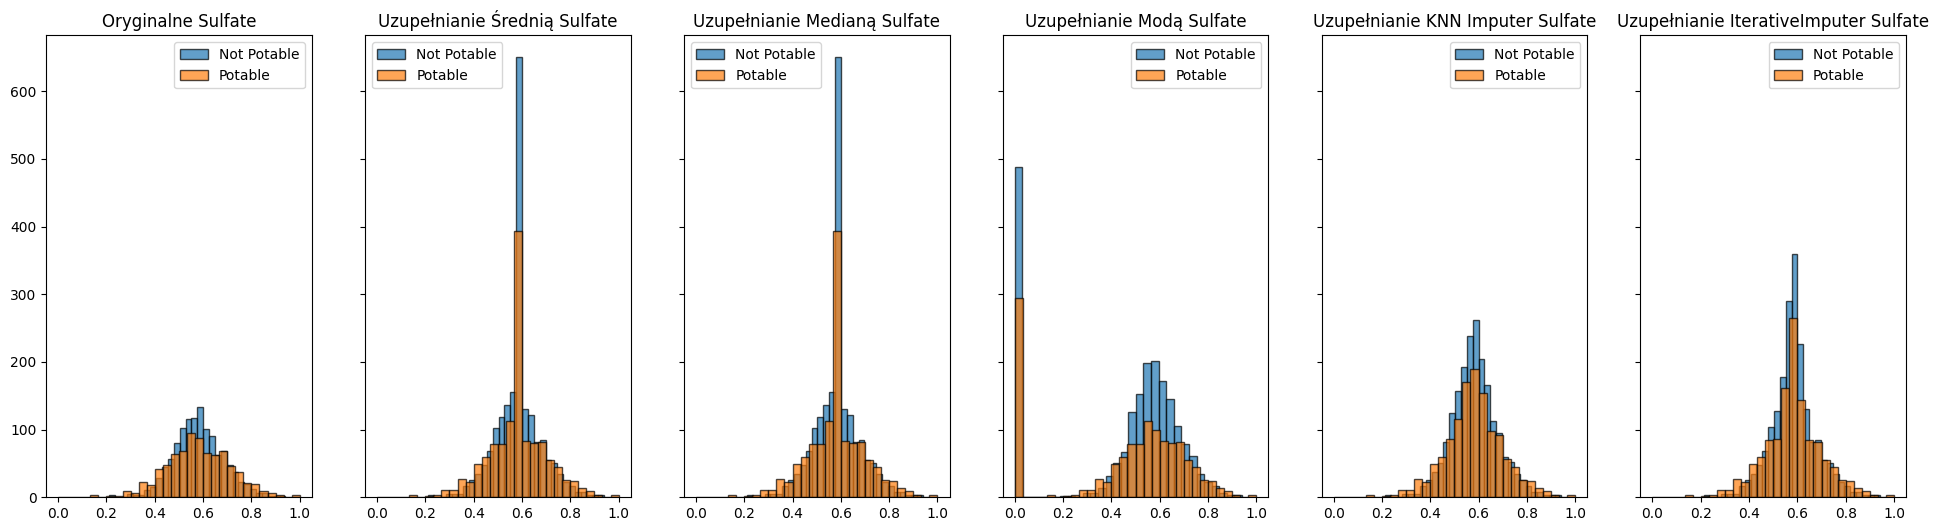

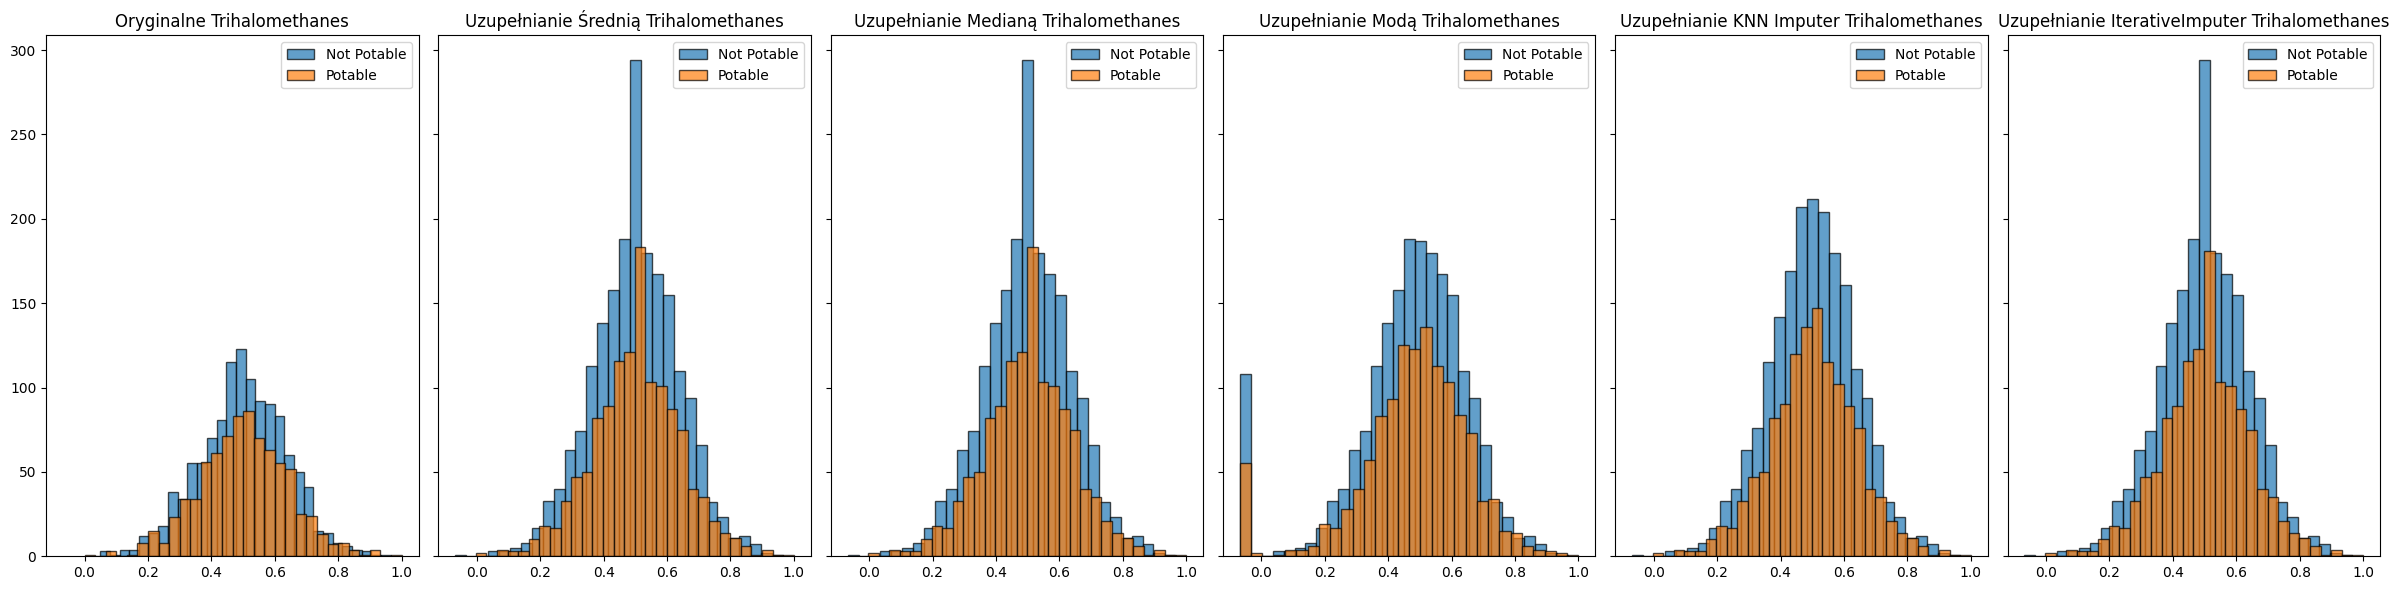

In [49]:

for col in ["ph", "Sulfate", "Trihalomethanes"]:
    fig, axes = plt.subplots(1, 6, figsize=(24, 6), sharex=True, sharey=True)

    cl0 = df_drop.loc[df["Potability"] == 0, col].dropna()
    cl1 = df_drop.loc[df["Potability"] == 1, col].dropna()
    axes[0].hist(cl0, bins=30, alpha=0.7, label='Not Potable', edgecolor='black')
    axes[0].hist(cl1, bins=30, alpha=0.7, label='Potable', edgecolor='black')
    axes[0].set_title(f'Oryginalne {col}')
    axes[0].legend()

    cl0 = df_mean.loc[df["Potability"] == 0, col]
    cl1 = df_mean.loc[df["Potability"] == 1, col]
    axes[1].hist(cl0, bins=30, alpha=0.7, label='Not Potable', edgecolor='black')
    axes[1].hist(cl1, bins=30, alpha=0.7, label='Potable', edgecolor='black')
    axes[1].set_title(f'Uzupełnianie Średnią {col}')
    axes[1].legend()

    cl0 = df_median.loc[df["Potability"] == 0, col]
    cl1 = df_median.loc[df["Potability"] == 1, col]
    axes[2].hist(cl0, bins=30, alpha=0.7, label='Not Potable', edgecolor='black')
    axes[2].hist(cl1, bins=30, alpha=0.7, label='Potable', edgecolor='black')
    axes[2].set_title(f'Uzupełnianie Medianą {col}')
    axes[2].legend()

    cl0 = df_mode.loc[df["Potability"] == 0, col]
    cl1 = df_mode.loc[df["Potability"] == 1, col]
    axes[3].hist(cl0, bins=30, alpha=0.7, label='Not Potable', edgecolor='black')
    axes[3].hist(cl1, bins=30, alpha=0.7, label='Potable', edgecolor='black')
    axes[3].set_title(f'Uzupełnianie Modą {col}')
    axes[3].legend()

    cl0 = df_knn_5.loc[df["Potability"] == 0, col]
    cl1 = df_knn_10.loc[df["Potability"] == 1, col]
    axes[4].hist(cl0, bins=30, alpha=0.7, label='Not Potable', edgecolor='black')
    axes[4].hist(cl1, bins=30, alpha=0.7, label='Potable', edgecolor='black')
    axes[4].set_title(f'Uzupełnianie KNN Imputer {col}')
    axes[4].legend()

    cl0 = df_iter.loc[df["Potability"] == 0, col]
    cl1 = df_iter.loc[df["Potability"] == 1, col]
    axes[5].hist(cl0, bins=30, alpha=0.7, label='Not Potable', edgecolor='black')
    axes[5].hist(cl1, bins=30, alpha=0.7, label='Potable', edgecolor='black')
    axes[5].set_title(f'Uzupełnianie IterativeImputer {col}')
    axes[5].legend()

plt.tight_layout()
plt.show()